In [1]:
# We just read every file and get all unique values for ordinal columns for feature financials
import os
import pandas as pd

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType


feature_financials_data = pd.read_csv("data/features_financials.csv")
loan_daily_data = pd.read_csv("data/lms_loan_daily.csv")
feature_attributes_data = pd.read_csv("data/features_attributes.csv")
feature_clickstream_data = pd.read_csv("data/feature_clickstream.csv")

columns = feature_financials_data.columns
print(columns)

Index(['Customer_ID', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'snapshot_date'],
      dtype='object')


In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

25/05/20 21:27:55 WARN Utils: Your hostname, kieren-Swift-SFX14-72G resolves to a loopback address: 127.0.1.1; using 10.169.129.154 instead (on interface wlp0s20f3)
25/05/20 21:27:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 21:27:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
unique_values = feature_financials_data.apply(pd.Series.unique)
print(unique_values)

Customer_ID                 [CUS_0x1000, CUS_0x1009, CUS_0x100b, CUS_0x101...
Annual_Income               [30625.94, 52312.68_, 113781.38999999998, 5891...
Monthly_Inhand_Salary       [2706.1616666666664, 4250.39, 9549.7825, 5208....
Num_Bank_Accounts           [6, 1, 3, 7, 2, 5, 8, 4, 0, 10, 9, 312, 933, 1...
Num_Credit_Card             [5, 4, 3, 7, 6, 8, 10, 9, 846, 2, 1, 726, 1375...
Interest_Rate               [27, 17, 1, 6, 16, 23, 9, 11, 2, 10, 30, 26, 5...
Num_of_Loan                 [2, 4, 0, 3, 8, 1, 1_, 9, 7, 6, 5, 119, 6_, 2_...
Type_of_Loan                [Credit-Builder Loan, and Home Equity Loan, No...
Delay_from_due_date         [57, 5, 14, 27, 12, 8, 19, 0, 6, 24, 13, 28, 5...
Num_of_Delayed_Payment      [26, 18, 8, 13, 9, 22, 5, 15, 17, 4, 6, 19, 11...
Changed_Credit_Limit        [1.63, 9.73, 8.34, 14.42, 1.33, 15.83, 28.63, ...
Num_Credit_Inquiries        [11.0, 4.0, 7.0, 3.0, 9.0, 8.0, 10.0, 5.0, 6.0...
Credit_Mix                                           [Bad, _, Go

Looks like there is alot of unclean data, and also alot of categorical, need to justify

In [4]:
print(unique_values['Payment_Behaviour'])

['High_spent_Medium_value_payments' 'High_spent_Small_value_payments'
 'Low_spent_Medium_value_payments' 'Low_spent_Small_value_payments'
 '!@9#%8' 'High_spent_Large_value_payments'
 'Low_spent_Large_value_payments']


Number of Bank Accounts


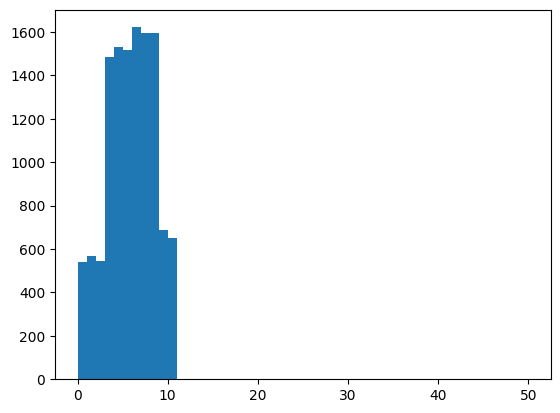

In [5]:
# We also see that there are some anomalous values like 729 credits cards or 119 loans, we can 
# Make a histograms of the value to see where would be a good cut off
import matplotlib.pyplot as plt 


plt.hist(feature_financials_data['Num_Bank_Accounts'], range=(0, 50), bins=50)
print("Number of Bank Accounts")

Monthly_Inhand_Salary


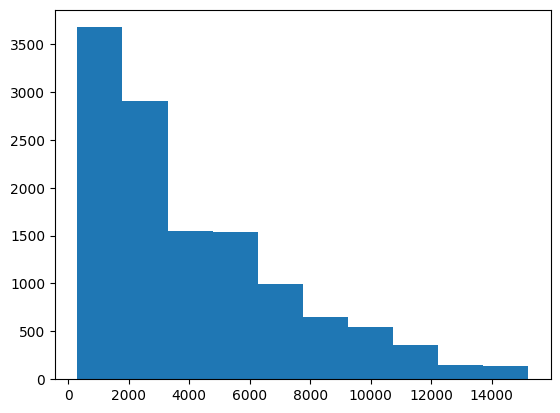

In [6]:
plt.hist(feature_financials_data['Monthly_Inhand_Salary'])
print("Monthly_Inhand_Salary")

Number of Credit cards


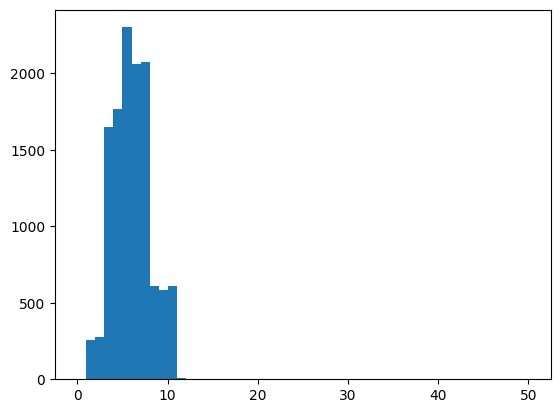

In [7]:
plt.hist(feature_financials_data['Num_Credit_Card'], range=(0, 50), bins=50)
print("Number of Credit cards")

Number of Loans


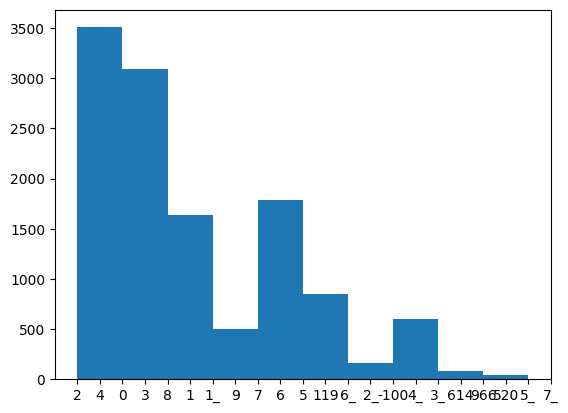

In [8]:
plt.hist(feature_financials_data['Num_of_Loan'], range=(0, 20), bins=10)
print("Number of Loans")

In [9]:
# We need to find all unique loan types
import re

def split_loans(loan_str):
    if pd.isna(loan_str):
        return []
    # Replace 'and' with comma, split by comma, strip whitespace, lower for uniformity
    parts = re.sub(r"\band\b", ",", loan_str, flags=re.IGNORECASE).split(",")
    cleaned = [p.strip() for p in parts if p.strip()]
    return cleaned

all_loans = []
feature_financials_data["Type_of_Loan"].apply(lambda x: all_loans.extend(split_loans(x)))

# Get unique loan types
unique_loans = set(all_loans)

print(unique_loans)

{'Not Specified', 'Student Loan', 'Payday Loan', 'Mortgage Loan', 'Personal Loan', 'Auto Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Credit-Builder Loan'}


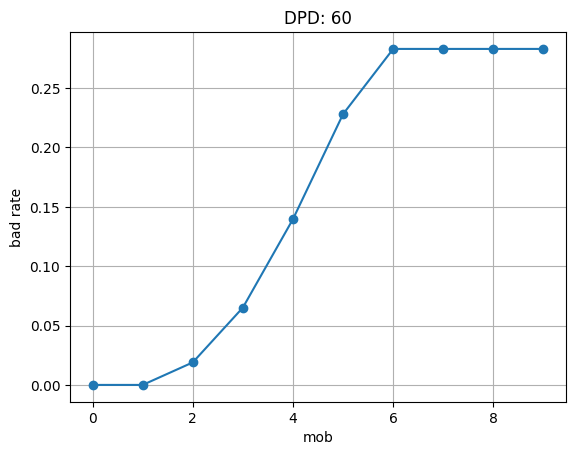

In [10]:
# Just to confirm the dpd thing
# set dpd label definition
dpd = 60

# Path to the folder containing CSV files
folder_path = os.path.join(os.getcwd(), "datamart", "silver")

# Read all CSV files into a single DataFrame
files_list = []
for csv_file in os.listdir(folder_path):
    if "lms_loan_daily" in csv_file:
        files_list.append(os.path.join(folder_path, csv_file))

# Read csv file and append
df = spark.read.option("header", "true").csv(files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()

In [11]:
unique_attributes = feature_attributes_data.apply(pd.Series.unique)
unique_attributes

Customer_ID      [CUS_0x1000, CUS_0x1009, CUS_0x100b, CUS_0x101...
Name             [Alistair Barrf, Arunah, Shirboni, Schneyerh, ...
Age              [18, 26, 19, 44, 27, 15, 52, 31, 40_, 45, 28, ...
SSN              [913-74-1218, 063-67-6938, #F%$D@*&8, 793-05-8...
Occupation       [Lawyer, Mechanic, Media_Manager, Doctor, Jour...
snapshot_date    [2023-05-01, 2025-01-01, 2024-03-01, 2023-11-0...
dtype: object

In [12]:
# We then get the unique jobs
unique_attributes['Occupation']

array(['Lawyer', 'Mechanic', 'Media_Manager', 'Doctor', 'Journalist',
       'Accountant', 'Manager', 'Entrepreneur', 'Scientist', 'Architect',
       'Teacher', '_______', 'Engineer', 'Writer', 'Developer',
       'Musician'], dtype=object)